In [2]:
import requests
from bs4 import BeautifulSoup
import re
import os

import random

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import csv
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

STOPWORDS = set(stopwords.words('english'))

print(tf.__version__)

2.1.0
[nltk_data] Downloading package stopwords to /home/robin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Function to scrape job openings from Indeed

In [3]:
def scraper(job_title):
    
    job_openings = [] # list with job opening text
    labels = [] # list with job opening labels
    
    main = "https://www.indeed.com/" # main indeed url
    
    for item in job_title:
    
        job = item.replace(" ", "+") # replace space in job title with dash

        for number in range(0, 500, 10): # will scrape 500 job openings

            url = f"{main}jobs?q={job}&start={number}" # compile job specific url

            page = requests.get(url) # request url

            soup = BeautifulSoup(page.content, "html.parser") # parse the page with beautifulsoup

            links = [a['href'] for a in soup.find_all('a', href=True)] # find all the urls on the page

            match_links = [main+s for s in links if "/rc/clk?jk=" in s] # find all the urls that link to job page

            for link in match_links: # loop through the 10 job ad urls on the page
                job_page = requests.get(link) # request the job ad url
                job_soup = BeautifulSoup(job_page.content, "html.parser") # parse the page
                
                

                for element in job_soup.find_all('div', attrs={"class":"jobsearch-jobDescriptionText"}): # loop through the job text
                    text = element.get_text(separator = " ").replace("\n","") # remove all tags from job text
                    
                    job_openings.append(text) # append job text tot job_openings
                    labels.append(item) # append job title
                    
    
    return job_openings, labels

The scraper can take a list with any number of job titles and will take the first 500 job openings.

In [5]:
job_openings = ["data scientist", "front-office manager", "front-end developer", "sales manager"]

jobs, labels = scraper(job_openings)

## Preparing the data

For convenience I have scraped the job openings of 4 job titles and put them in a csv so I don't have to run the scraper every session (it takes some time to complete). 

First, load the csv and randomize

In [3]:
df = pd.read_csv('data/data-set.csv')
df = df.sample(frac=1).reset_index(drop=True)

conditions = [
    (df['labels'] == 'data scientist'),
    (df['labels'] == 'sales manager'),
    (df['labels'] == 'front-office manager'),
    (df['labels'] == 'front-end developer')]
choices = [0, 1, 2, 3]
df['labels_num'] = np.select(conditions, choices) # make label column numerica

jobs = df['jobs'].to_numpy()
labels = df['labels_num'].to_numpy()

Then, remove the stopwords

In [4]:
jobs_clean = []

for i in jobs:
    job = i
    for word in STOPWORDS:
        token = ' ' + word + ' '
        job = job.replace(token, ' ')
        job = job.replace(' ', ' ')
    jobs_clean.append(job)

Then, set our paramaters

In [5]:
vocab_size = 8000 # most common words
embedding_dim = 64
max_length = 600
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # not in word index
training_portion = .8 # portion of training set

One-hot-encode label column

In [6]:
labels = tf.keras.utils.to_categorical(labels, num_classes=4)

Convert them to a train and test set

In [7]:
train_size = int(len(jobs_clean) * training_portion)

train_jobs = jobs_clean[0: train_size]
train_labels = labels[0: train_size]

validation_jobs = jobs_clean[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_jobs))
print(len(train_labels))
print(len(validation_jobs))
print(len(validation_labels))

1601
1601
1601
401
401


Tokenizer

OOV is the most common, followed by experience, etc.

In [8]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_jobs)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'experience': 2,
 'data': 3,
 'work': 4,
 'sales': 5,
 'team': 6,
 'skills': 7,
 'business': 8,
 'ability': 9,
 'the': 10}

Turn into list of sequence

In [9]:
train_sequences = tokenizer.texts_to_sequences(train_jobs)
print(train_sequences[10]) # 11th job opening

[4113, 901, 1020, 104, 3, 221, 184, 3, 103, 6, 81, 1, 901, 1479, 2128, 1, 3318, 861, 3319, 829, 15, 3319, 10, 3, 103, 6, 3119, 590, 611, 3, 103, 392, 1130, 1, 8, 165, 1354, 531, 733, 1487, 1593, 293, 45, 2164, 3, 103, 6, 1356, 818, 8, 2242, 36, 2102, 409, 724, 79, 1065, 3, 8, 876, 1356, 147, 293, 291, 703, 914, 487, 1, 293, 27, 1294, 114, 68, 3, 221, 96, 363, 8, 165, 3683, 940, 696, 620, 8, 409, 192, 117, 1452, 212, 210, 557, 444, 941, 136, 3316, 171, 993, 71, 411, 295, 190, 22, 289, 333, 92, 1929, 171, 374, 75, 36, 276, 354, 189, 970, 171, 136, 392, 99, 456, 1133, 606, 297, 762, 456, 652, 647, 34, 1551, 1629, 606, 297, 430, 76, 372, 51, 85, 42, 525, 268, 144, 25, 2, 2290, 3, 136, 293, 99, 8, 396, 245, 66, 58, 285, 802, 258, 85, 42, 525, 268, 412, 25, 2, 2290, 3, 136, 293, 99, 8, 396, 245, 66, 4113, 1908, 191, 1, 20, 1050, 51, 85, 42, 525, 268, 144, 25, 2, 2290, 3, 136, 293, 99, 8, 396, 245, 43, 2, 727, 3, 1720, 190, 6072, 6604, 1821, 378, 1, 1821, 2198, 769, 3, 3117, 61, 76, 1196, 51,

In [27]:
type(train_jobs)

list

In [23]:
train_sequences[0]

[23,
 509,
 2032,
 174,
 775,
 605,
 14,
 1288,
 1583,
 196,
 68,
 146,
 866,
 563,
 16,
 489,
 14,
 64,
 127,
 1607,
 3,
 1191,
 1238,
 5620,
 94,
 7251,
 657,
 1505,
 2542,
 7251,
 1811,
 2804,
 4093,
 626,
 35,
 1,
 1679,
 6053,
 2543,
 2930,
 2662,
 7251,
 1378,
 6583,
 1922,
 78,
 1626,
 411,
 2473,
 1192,
 172,
 64,
 39,
 563,
 792,
 2473,
 124,
 908,
 1176,
 1013,
 95,
 20,
 462,
 72,
 1565,
 196,
 1,
 433,
 6054,
 1088,
 1367,
 6583,
 1922,
 5621,
 7252,
 1014,
 461,
 1,
 1,
 1139,
 1,
 1872,
 522,
 2473,
 1872,
 113,
 209,
 109,
 156,
 563,
 196,
 64,
 2033,
 489,
 14,
 1139,
 563,
 927,
 139,
 179,
 694,
 3535,
 427,
 3027,
 2805,
 4482,
 1426,
 14,
 3535,
 549,
 7253,
 3028,
 245,
 16,
 14,
 1367,
 427,
 146,
 305,
 110,
 67,
 118,
 118,
 1812,
 657,
 14,
 21,
 43,
 66,
 310,
 21,
 1379,
 15,
 4483,
 14,
 522,
 124,
 657,
 3,
 1191,
 331,
 4721,
 1,
 7254,
 1070,
 7251,
 582,
 4094,
 142,
 1566,
 47,
 163,
 34,
 652,
 2544,
 4284,
 4966,
 2806,
 717,
 3304,
 2473,
 1192,
 40

Pad sequences so they are all the same size. train_padded is length 500

In [10]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0])) # old
print(len(train_padded[0])) # new

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

615
600
782
600
355
600


Do the same for validation sequences

In [11]:
validation_sequences = tokenizer.texts_to_sequences(validation_jobs)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

401
(401, 600)


Compare original job text and job text after padding and tokenization

In [12]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_job(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_job(train_padded[12]))
print('---')
print(train_jobs[12])

project manager sales operations <OOV> no visa sponsorship available position preferred qualifications job description as senior project manager north america applications sales operations team responsible contributing short term long range business planning ultimate goal improving sales process efficiency overall sales productivity you collect verify analyze sales operations data measure key performance indicators make recommendations implement programs aimed improving business processes we looking someone team player possesses unique ability craft strategic vision roll sleeves make vision reality responsibilities serve project manager variety sales operations projects – lead teams hit milestones ensure project status progress communicated stakeholders partner technical teams improve sales tools automate much possible sales manager coaching quarterly business reviews include account planning white space install base reporting executive relationship scoring opportunity sales play progr

## Building the model

## Try #1 - Stacked LSTM layers

In [ ]:
# vocab_size = 8000 # most common words
# embedding_dim = 64
# max_length = 600

In [89]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 8000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
    # Extra LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 4 nodes (1 for each class) and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 64)          512000    
_________________________________________________________________
bidirectional_9 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 260       
Total params: 623,684
Trainable params: 623,684
Non-trainable params: 0
_________________________________________________________________


In [90]:
train_padded_array = np.asarray(train_padded)


model.compile(loss='categorical_croentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 50
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)

Train on 1601 samples, validate on 401 samples
Epoch 1/50
1601/1601 - 92s - loss: 1.1418 - accuracy: 0.4703 - val_loss: 0.7719 - val_accuracy: 0.6534
Epoch 2/50
1601/1601 - 95s - loss: 0.4826 - accuracy: 0.8089 - val_loss: 0.4263 - val_accuracy: 0.8628
Epoch 3/50
1601/1601 - 89s - loss: 0.2857 - accuracy: 0.9082 - val_loss: 0.3196 - val_accuracy: 0.9027
Epoch 4/50
1601/1601 - 96s - loss: 0.2112 - accuracy: 0.9500 - val_loss: 0.4785 - val_accuracy: 0.8554
Epoch 5/50
1601/1601 - 95s - loss: 0.1271 - accuracy: 0.9763 - val_loss: 0.3654 - val_accuracy: 0.8953
Epoch 6/50
1601/1601 - 97s - loss: 0.1041 - accuracy: 0.9731 - val_loss: 0.3680 - val_accuracy: 0.8928
Epoch 7/50
1601/1601 - 93s - loss: 0.0507 - accuracy: 0.9869 - val_loss: 0.4115 - val_accuracy: 0.8953
Epoch 8/50
1601/1601 - 99s - loss: 0.0309 - accuracy: 0.9944 - val_loss: 0.3910 - val_accuracy: 0.9152
Epoch 9/50
1601/1601 - 93s - loss: 0.0340 - accuracy: 0.9938 - val_loss: 0.3881 - val_accuracy: 0.9102
Epoch 10/50
1601/1601 - 99

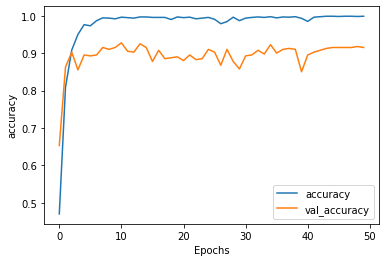

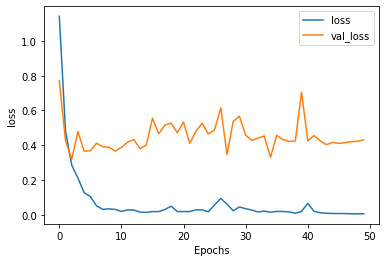

In [95]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

A big gap between val_loss and training loss, indicating overfit

## Try #2 - Very simple single LSTM layer

In [96]:
# vocab_size = 8000 # most common words
# embedding_dim = 64
# max_length = 600

In [13]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 8000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 4 nodes (1 for each class) and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          512000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 586,564
Trainable params: 586,564
Non-trainable params: 0
_________________________________________________________________


In [14]:
train_padded_array = np.asarray(train_padded)


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 5
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)

Train on 1601 samples, validate on 401 samples
Epoch 1/5
1601/1601 - 49s - loss: 1.2428 - accuracy: 0.4054 - val_loss: 1.0550 - val_accuracy: 0.5187
Epoch 2/5
1601/1601 - 50s - loss: 0.5575 - accuracy: 0.8207 - val_loss: 0.2834 - val_accuracy: 0.9252
Epoch 3/5
1601/1601 - 44s - loss: 0.2957 - accuracy: 0.9132 - val_loss: 0.2323 - val_accuracy: 0.9302
Epoch 4/5
1601/1601 - 44s - loss: 0.0615 - accuracy: 0.9869 - val_loss: 0.1483 - val_accuracy: 0.9526
Epoch 5/5
1601/1601 - 44s - loss: 0.0897 - accuracy: 0.9788 - val_loss: 0.2176 - val_accuracy: 0.9302


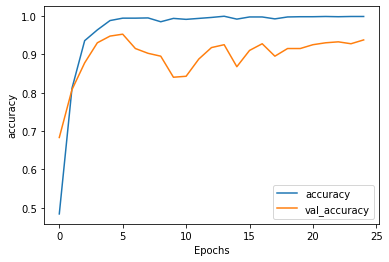

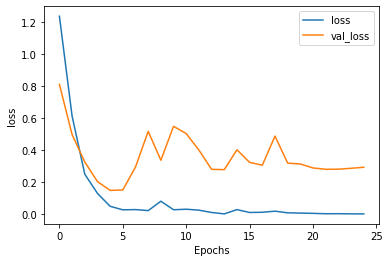

In [114]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Save model

In [16]:
model.save('model/model1.h5')

In [13]:
import pickle

# saving
with open('model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('model/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## CV inlezen

In [15]:
import docx

doc =  docx.Document('data/CV_robinfaber.docx')

In [16]:
def getText(filename):
    doc = docx.Document(filename)
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text.replace('\t', ' '))
    return ' '.join(fullText)

In [17]:
text = getText('data/CV_robinfaber.docx')

In [18]:
type(text)

str

In [19]:
for i in text:
    job = i
    for word in STOPWORDS:
        token = ' ' + word + ' '
        job = job.replace(token, ' ')
        job = job.replace(' ', ' ')
    jobs_clean.append(job)

In [65]:
seq = tokenizer.texts_to_sequences(text)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['data scientist', 'sales manager', 'front-office manager', 'front-end developer']
print(pred, labels[np.argmax(pred)])

IndexError: list index out of range

In [76]:
padded

array([[   0,    0,    0, ...,    0,    0,  266],
       [   0,    0,    0, ...,    0,    0, 1661],
       [   0,    0,    0, ...,    0,    0,  761],
       ...,
       [   0,    0,    0, ...,    0,    0, 2819],
       [   0,    0,    0, ...,    0,    0,  320],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [24]:
np.argmax(pred)

NameError: name 'pred' is not defined

In [25]:
seq

NameError: name 'seq' is not defined